# Using Aggregate

Build and examine a graph that contains some sort of aggregate operation.

## Base Builder

Starting from previous code, build our own custom dict thingy.

In [1]:
from typing import List
import awkward as ak
import dask_awkward as dak
import random
import dask

def make_input_layer(name, inputs: List[str]):
    # Each file that returns will be simulated by a block of 100 numbers.
    # Call with a string that is the block number.
    def generate_data(block):
        print(f'In generate_data: {block}')
        return ak.from_iter([random.uniform(0, 10) for i in range(0, 100)])

    # Build the sample array up    
    # TODO: We have to go into core here - does this mean `typetracer_array` is not a good thing to access? If not, how should we do this?
    sample_array = ak.from_iter([1, 2, 3, 4, 5])
    metadata = dak.core.typetracer_array(sample_array)

    # Next, create the input layer that will be used to generate the data.
    dsk = dak.layers.AwkwardInputLayer(
            name=name,
            columns=None,
            inputs=inputs,
            io_func=generate_data,
            meta=metadata,
            behavior=None,
        )

    return dsk

def generate_sx_daq(query: str, inputs: List[str] = ['0', '1']) -> dak.Array:
    name = 'unique-name'
    input_layer = make_input_layer(name, inputs)

    # Create the high level graph that will hold all of this, and the actual array object
    hlg = dask.highlevelgraph.HighLevelGraph.from_collections(name, input_layer)
    ar = dak.core.new_array_object(hlg, name, meta=input_layer._meta, npartitions=len(inputs))

    return ar

# Doing a length or count operation

Lets build the length/count operation - see that it works - and then look at the high level layer layout.

In generate_data: 0
In generate_data: 1


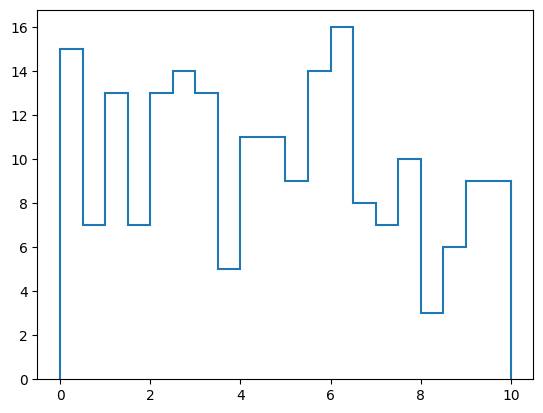

In [2]:
import dask_histogram as dh
import mplhep as hep

x = generate_sx_daq("(query)")
h = dh.factory(x, axes=(dh.axis.Regular(20, 0, 10),))
r = h.compute()
_ = hep.histplot(r)

Lets look at the dask compute DAG

In [3]:
h.dask

HighLevelGraph with 3 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x230c9dfbd90>
 0. unique-name
 1. hist-on-block-7bdff784c0c4b2931e89b221570d59f2
 2. hist-aggregate-de7c912ada723c50e47fa15960ba20a2

Separate layers for each - can we go in after the first layer and "alter" it?

In [4]:
dsk = h.dask
print(type(dsk))

<class 'dask.highlevelgraph.HighLevelGraph'>


In [5]:
help(dsk)

Help on HighLevelGraph in module dask.highlevelgraph object:

class HighLevelGraph(collections.abc.Mapping)
 |  HighLevelGraph(layers: 'Mapping[str, Mapping]', dependencies: 'Mapping[str, Set]', key_dependencies: 'dict[Hashable, Set] | None' = None)
 |  
 |  Task graph composed of layers of dependent subgraphs
 |  
 |  This object encodes a Dask task graph that is composed of layers of
 |  dependent subgraphs, such as commonly occurs when building task graphs
 |  using high level collections like Dask array, bag, or dataframe.
 |  
 |  Typically each high level array, bag, or dataframe operation takes the task
 |  graphs of the input collections, merges them, and then adds one or more new
 |  layers of tasks for the new operation.  These layers typically have at
 |  least as many tasks as there are partitions or chunks in the collection.
 |  The HighLevelGraph object stores the subgraphs for each operation
 |  separately in sub-graphs, and also stores the dependency structure between
 

In [6]:
dsk.layers

{'unique-name': AwkwardInputLayer<unique-name>,
 'hist-on-block-7bdff784c0c4b2931e89b221570d59f2': Blockwise<(('unique-name', ('.0',)), (None, None), (None, None)) -> hist-on-block-7bdff784c0c4b2931e89b221570d59f2>,
 'hist-aggregate-de7c912ada723c50e47fa15960ba20a2': <dask.highlevelgraph.MaterializedLayer at 0x230cb622050>}

In [7]:
dsk.dependencies

{'unique-name': set(),
 'hist-on-block-7bdff784c0c4b2931e89b221570d59f2': {'unique-name'},
 'hist-aggregate-de7c912ada723c50e47fa15960ba20a2': {'hist-on-block-7bdff784c0c4b2931e89b221570d59f2'}}

In [8]:
my_input = dsk.layers['unique-name']
my_input

AwkwardInputLayer<unique-name>

In [9]:
help(my_input)

Help on AwkwardInputLayer in module dask_awkward.layers.layers object:

class AwkwardInputLayer(dask.blockwise.Blockwise)
 |  AwkwardInputLayer(*, name: 'str', columns: 'str | list[str] | None', inputs: 'Any', io_func: 'Callable', meta: 'Any', behavior: 'dict | None', label: 'str | None' = None, produces_tasks: 'bool' = False, creation_info: 'dict | None' = None, annotations: 'Mapping[str, Any] | None' = None) -> 'None'
 |  
 |  Method resolution order:
 |      AwkwardInputLayer
 |      dask.blockwise.Blockwise
 |      dask.highlevelgraph.Layer
 |      collections.abc.Mapping
 |      collections.abc.Collection
 |      collections.abc.Sized
 |      collections.abc.Iterable
 |      collections.abc.Container
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *, name: 'str', columns: 'str | list[str] | None', inputs: 'Any', io_func: 'Callable', meta: 'Any', behavior: 'dict | None', label: 'str | None' = None, produces_tasks: 'bool' = False, creation_info: 'dict 

In [10]:
print(f'dims: {my_input.dims}')
print(f'items: {my_input.items}')
print(f'keys: {list(my_input.keys())}')

dims: {'i': 2}
items: <bound method Mapping.items of AwkwardInputLayer<unique-name>>
keys: [('unique-name', 0), ('unique-name', 1)]


This is probably obvious to most people - but it looks like it isn't the `HighLevelLayer` we want to alter, but rather the `AwkwardInputLayer` that we want to mess with. Though from above it looks like both the awkward array object and the input layer both independently know about the number of partitions (which is a little weird).

So - lets hit this with a hammer - just create a new awkward layer that has a different number of inputs and see what happens.

In [11]:
new_input = make_input_layer('unique-name', inputs=['0', '1', '2', '3'])
print(f'keys: {list(new_input.keys())}')

keys: [('unique-name', 0), ('unique-name', 1), ('unique-name', 2), ('unique-name', 3)]


Moment of truth...

In [12]:
dsk.layers['unique-name'] = new_input
dsk

HighLevelGraph with 3 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x230c9dfbd90>
 0. unique-name
 1. hist-on-block-7bdff784c0c4b2931e89b221570d59f2
 2. hist-aggregate-de7c912ada723c50e47fa15960ba20a2

And we can see the layer2 there still has only 2 outputs, but I suspect it should have 4. Lets compare:

In [13]:
x_expected = generate_sx_daq("(query)", inputs=['0', '1', '2', '3'])
h_expected = dh.factory(x_expected, axes=(dh.axis.Regular(20, 0, 10),))
h_expected.dask

HighLevelGraph with 3 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x230cb7ede50>
 0. unique-name
 1. hist-on-block-aafc78a25513b317b311f34b85beaa77
 2. hist-aggregate-0c88dd2655d7368019088612b55ffe4f

Ok - so it has 4 here... So we still need to modify the second layer somehow. This means being a little more invasive. We have to get into that second layer and somehow fix that up too. So, lets see what it looks like...

In [14]:
hist_on_block_key = [k for k in dsk.layers.keys() if k.startswith('hist-on-block')][0]
block_layer = dsk.layers[hist_on_block_key]
block_layer

Blockwise<(('unique-name', ('.0',)), (None, None), (None, None)) -> hist-on-block-7bdff784c0c4b2931e89b221570d59f2>

Adjust the number of inputs...

In [15]:
print(block_layer.numblocks)
block_layer.numblocks = (4,)
print(block_layer.numblocks)
block_layer

{'unique-name': (2,)}
(4,)


Blockwise<(('unique-name', ('.0',)), (None, None), (None, None)) -> hist-on-block-7bdff784c0c4b2931e89b221570d59f2>

In [16]:
[i for i in block_layer.items()]

AssertionError: 

So the number of outputs is still wrong. Need to get that fixed...

In [17]:
block_layer._dims = {'.0': 4}
block_layer

Blockwise<(('unique-name', ('.0',)), (None, None), (None, None)) -> hist-on-block-7bdff784c0c4b2931e89b221570d59f2>

Ok - the layer looks good - how does the rest of the graph look?

In [18]:
dsk

HighLevelGraph with 3 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x230c9dfbd90>
 0. unique-name
 1. hist-on-block-7bdff784c0c4b2931e89b221570d59f2
 2. hist-aggregate-de7c912ada723c50e47fa15960ba20a2

Lets see what happens when it runs. We've been modifying this dsak thing in place... so we should just be able to execute it...

In [19]:
h.compute()

TypeError: cannot convert dictionary update sequence element #0 to a sequence